In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
train_data = pd.read_csv(r"/kaggle/input/playground-series-s4e5/train.csv")
test_data = pd.read_csv(r"/kaggle/input/playground-series-s4e5/test.csv")
train_data.shape, test_data.shape

((1117957, 22), (745305, 21))

In [7]:
train_data.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [8]:
train_data = train_data.drop("id", axis = 1)

In [9]:
train_data.corr()["FloodProbability"]

MonsoonIntensity                   0.189098
TopographyDrainage                 0.187635
RiverManagement                    0.187131
Deforestation                      0.184001
Urbanization                       0.180861
ClimateChange                      0.184761
DamsQuality                        0.187996
Siltation                          0.186789
AgriculturalPractices              0.183366
Encroachments                      0.178841
IneffectiveDisasterPreparedness    0.183109
DrainageSystems                    0.179305
CoastalVulnerability               0.177774
Landslides                         0.185346
Watersheds                         0.181907
DeterioratingInfrastructure        0.190007
PopulationScore                    0.185890
WetlandLoss                        0.183396
InadequatePlanning                 0.180968
PoliticalFactors                   0.182417
FloodProbability                   1.000000
Name: FloodProbability, dtype: float64

In [10]:
X = train_data.drop("FloodProbability", axis = 1)
y = train_data["FloodProbability"]

# test df

In [11]:
test_data.drop("id", axis = 1, inplace = True)

In [12]:
column_names = X.columns

In [13]:
sc = StandardScaler()
X = sc.fit_transform(X)
test_data = sc.transform(test_data)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Model training
documentation : https://www.kaggle.com/code/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example

In [15]:
model_params = {
    "n_estimators" : 1000,
    "learning_rate" : 0.01,
    "max_depth" : 10,
    "device" : device
}

In [16]:
eval_set = [(X_val, y_val)]

In [17]:
model_XGB = XGBRegressor(**model_params)
model_XGB.fit(X_train, y_train, eval_set=eval_set, verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Experiments

In [38]:
temp = train_data.copy()
column_names

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

In [39]:
temp.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [40]:
X = temp.drop("FloodProbability", axis = 1)
y = temp["FloodProbability"]

In [41]:
for i, column in enumerate(column_names):
    if i == 0:
        continue
    X[f"sum_of_{i}"] = X[list(column_names[:i])].sum(axis = 1)

In [42]:
X.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,sum_of_10,sum_of_11,sum_of_12,sum_of_13,sum_of_14,sum_of_15,sum_of_16,sum_of_17,sum_of_18,sum_of_19
0,5,8,5,8,6,4,4,3,3,4,...,50,52,57,60,63,68,72,79,84,91
1,6,7,4,4,8,8,3,5,4,6,...,55,64,71,73,73,76,81,84,87,91
2,6,5,6,7,3,7,1,5,4,5,...,49,55,62,65,72,77,83,91,93,96
3,3,4,6,5,4,8,4,7,6,8,...,55,60,62,66,73,77,81,87,92,99
4,5,3,2,6,4,4,3,3,3,3,...,36,41,43,45,51,57,61,62,64,67


In [47]:
test_data = pd.read_csv(r"/kaggle/input/playground-series-s4e5/test.csv")
test_data.drop("id", axis = 1, inplace = True)
for i, column in enumerate(column_names):
    if i == 0:
        continue
    test_data[f"sum_of_{i}"] = test_data[list(column_names[:i])].sum(axis = 1)

In [48]:
X = sc.fit_transform(X)
test_data = sc.transform(test_data)

In [49]:
model_XGB.fit(X, y, verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Submission

In [50]:
y_pred = model_XGB.predict(test_data)

In [51]:
test_data_id = pd.read_csv(r"/kaggle/input/playground-series-s4e5/test.csv")["id"]
test_data_id

0         1117957
1         1117958
2         1117959
3         1117960
4         1117961
           ...   
745300    1863257
745301    1863258
745302    1863259
745303    1863260
745304    1863261
Name: id, Length: 745305, dtype: int64

In [52]:
submission = pd.DataFrame(list(zip(test_data_id, y_pred)), columns = ["id", "FloodProbability"])
submission.head()

,id,FloodProbability
0,1117957,0.681708
1,1117958,0.687940
2,1117959,0.694874
3,1117960,0.692744
4,1117961,0.692225


In [53]:
submission.to_csv("submission.csv", index = False)

# SHAP

In [54]:
import xgboost as xgb
import shap
shap.initjs()

In [55]:
dmat = xgb.DMatrix(X, y)
bst  = xgb.train({"tree_method": "gpu_hist"}, dmat, 500)
# Make sure GPU prediction is enabled
bst.set_param({"predictor": "gpu_predictor"})

In [56]:
%time
shap_values = bst.predict(dmat, pred_contribs=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


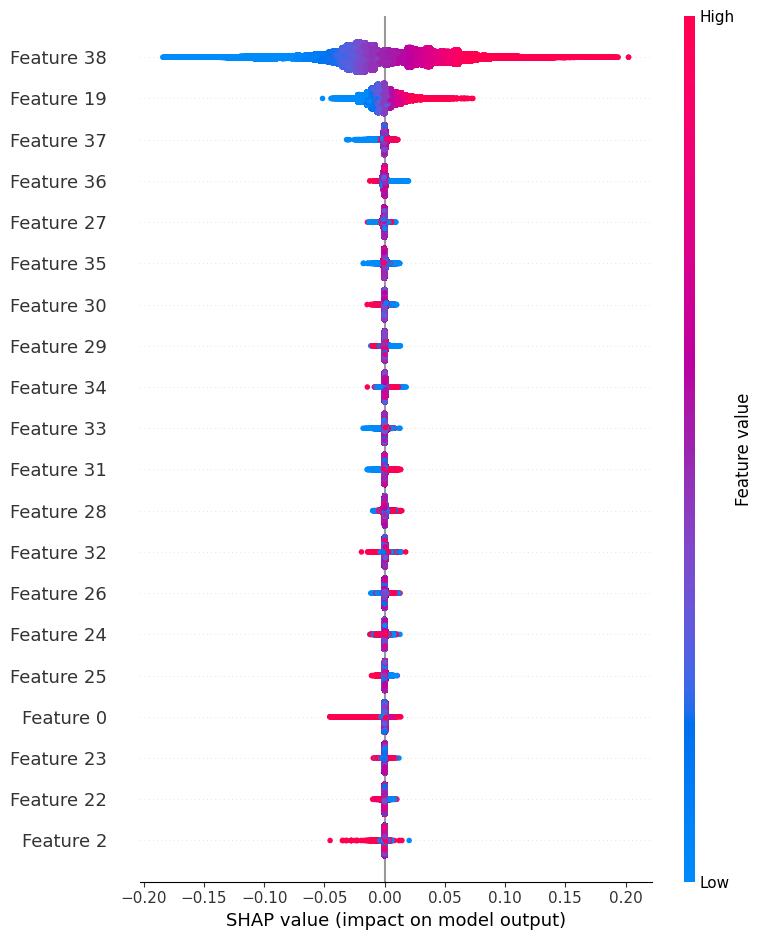

In [57]:
shap.summary_plot(shap_values[:,:-1], X)